## Phase 4 Data Mining
In this notebook we use machine learning to analyze the detection of each of the Modbus Protocol attacks: 
- Arp-based Man in the Middle (mitm)
- TCP SYN flooding
- Modbus Query flood
- Ping flooding

In [101]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# Suppress User Warning messages
warnings.simplefilter(action='ignore', category=UserWarning)

In [102]:
# Loading the datasets and concatenating them into one df
files = ['clean.csv', 'mitm.csv', 'modbusQuery2Flooding.csv', 'modbusQueryFlooding.csv', 'pingFloodDDos.csv', 'tcpSYNFlood.csv']
data = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)


relevant_features = ['Length',
                    'Protocol',
                    # 'SrcIP',
                    # 'DstIP',
                    # 'SrcPort',
                    # 'DstPort',
                    'SYNFlag',
                    'ACKFlag',
                    'TimeDelta',
                    'RelativeTime', 
                    # 'EpochTime',
                    'AttackName']

data = data[relevant_features]

Unique values in 'AttackName' before mapping: ['Clean' 'mitm' 'modbusQuery2Flooding' 'modbusQueryFlooding'
 'pingFloodDDoS' 'tcpSYNFloodDDoS']


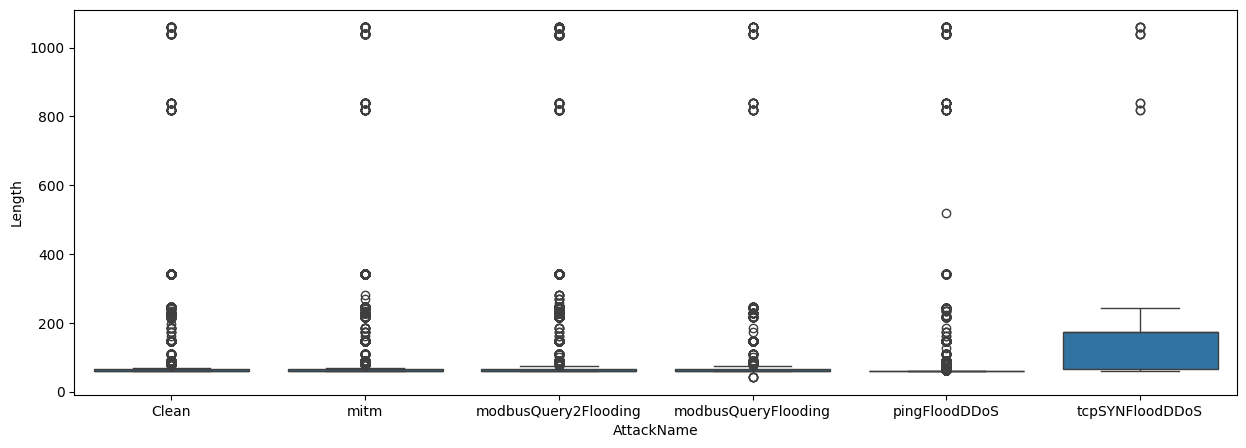

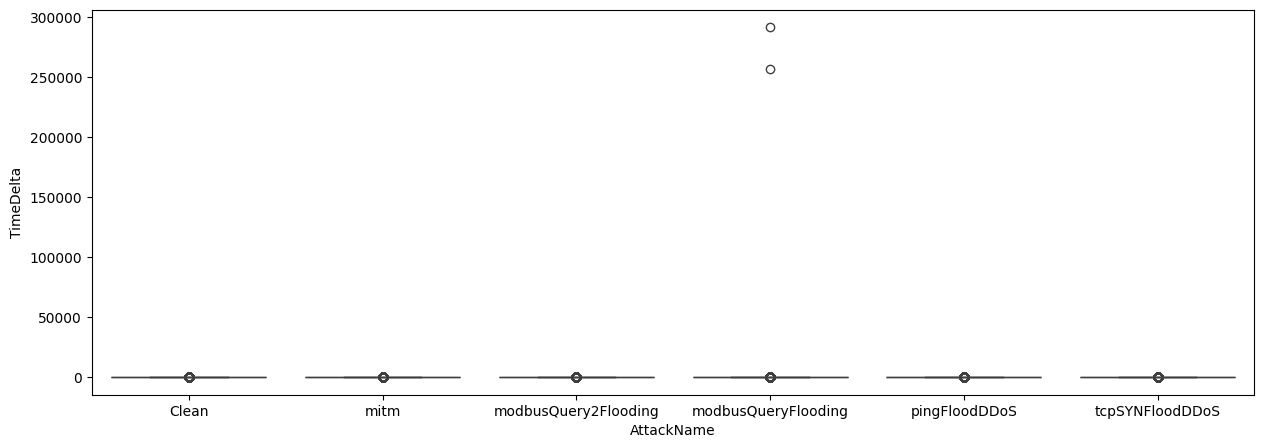

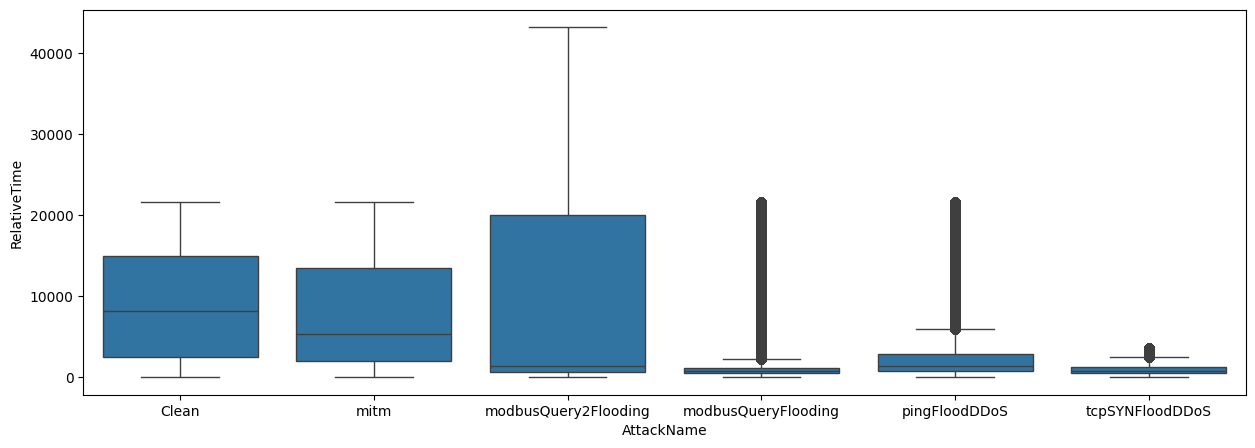

In [103]:
numeric_features = [
    "Length",
    "TimeDelta",
    "RelativeTime",
]


print("Unique values in 'AttackName' before mapping:", data['AttackName'].unique())


# For each column in the DataFrame
for column in numeric_features:
    # Create a boxplot
    plt.figure(figsize=(15, 5))
    sns.boxplot(x='AttackName', y = column, data=data)
    plt.show()


epoch timestamp does not change in relation to the attack type

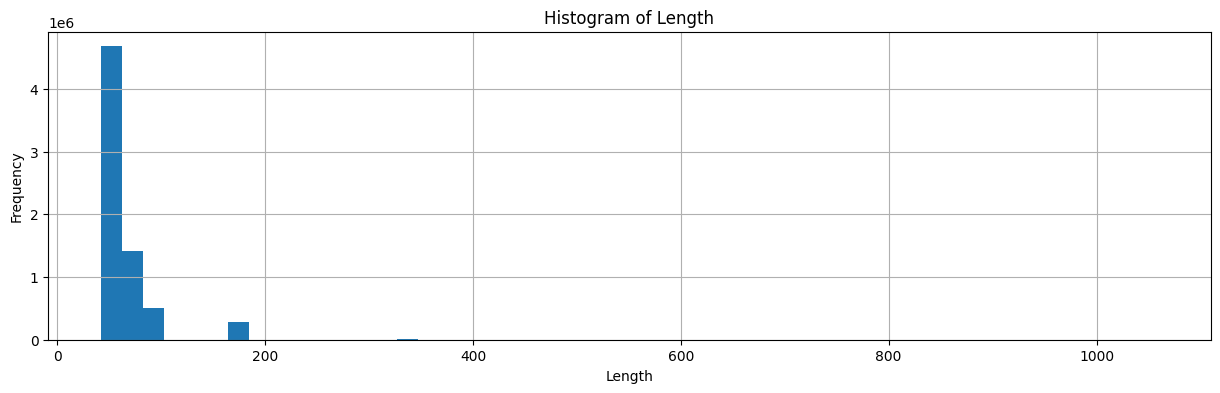

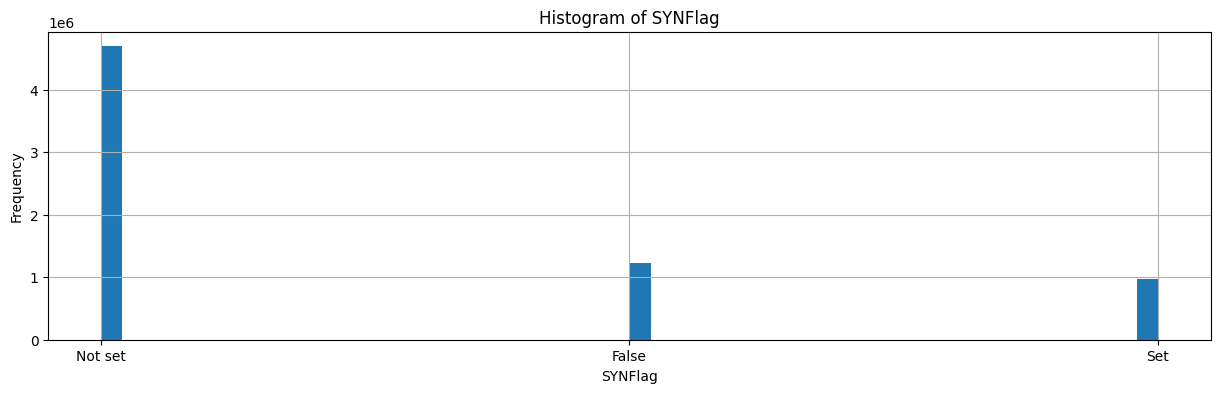

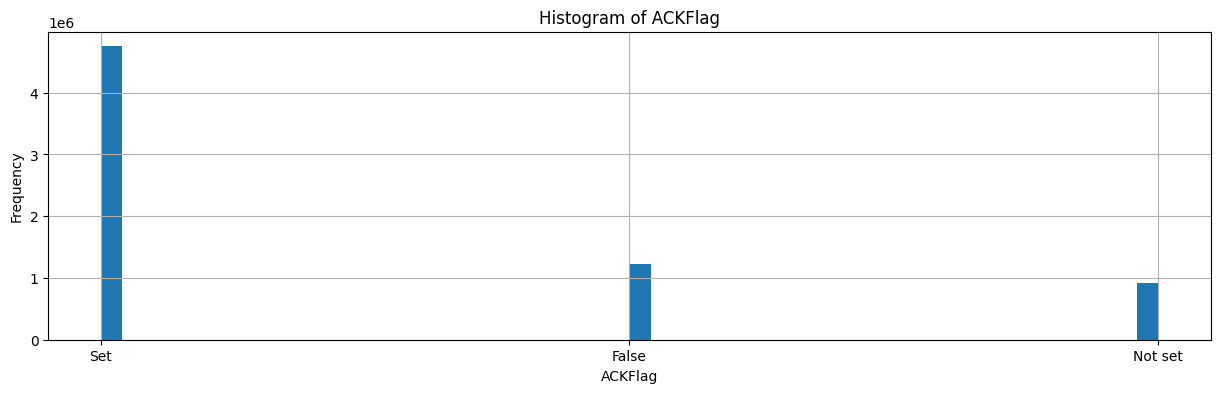

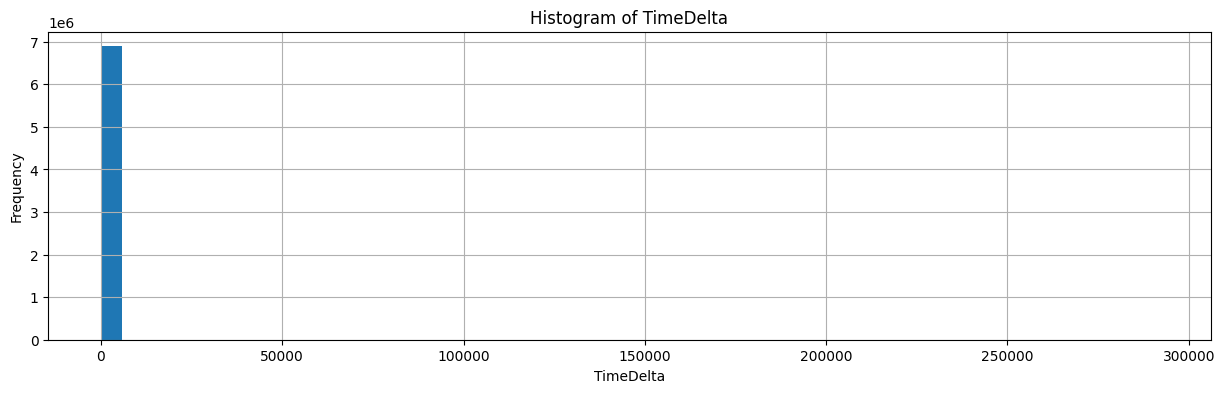

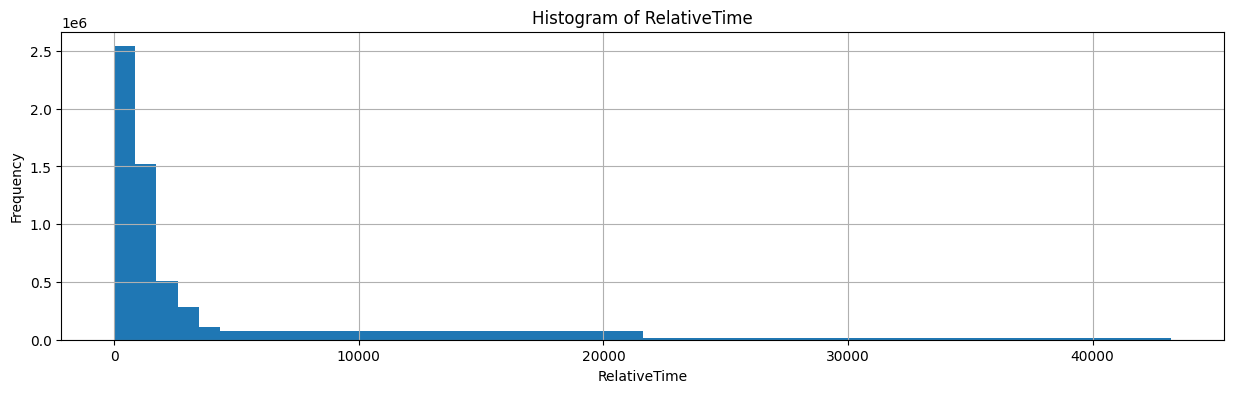

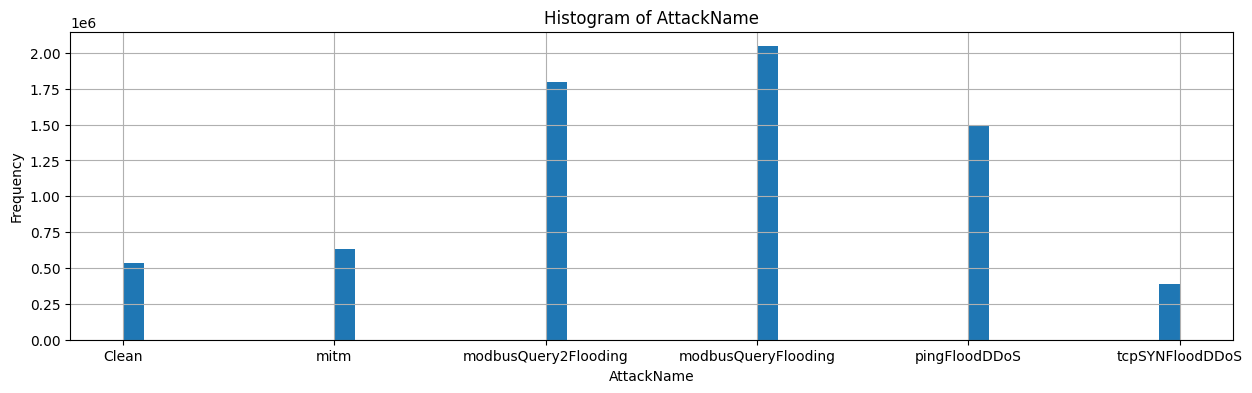

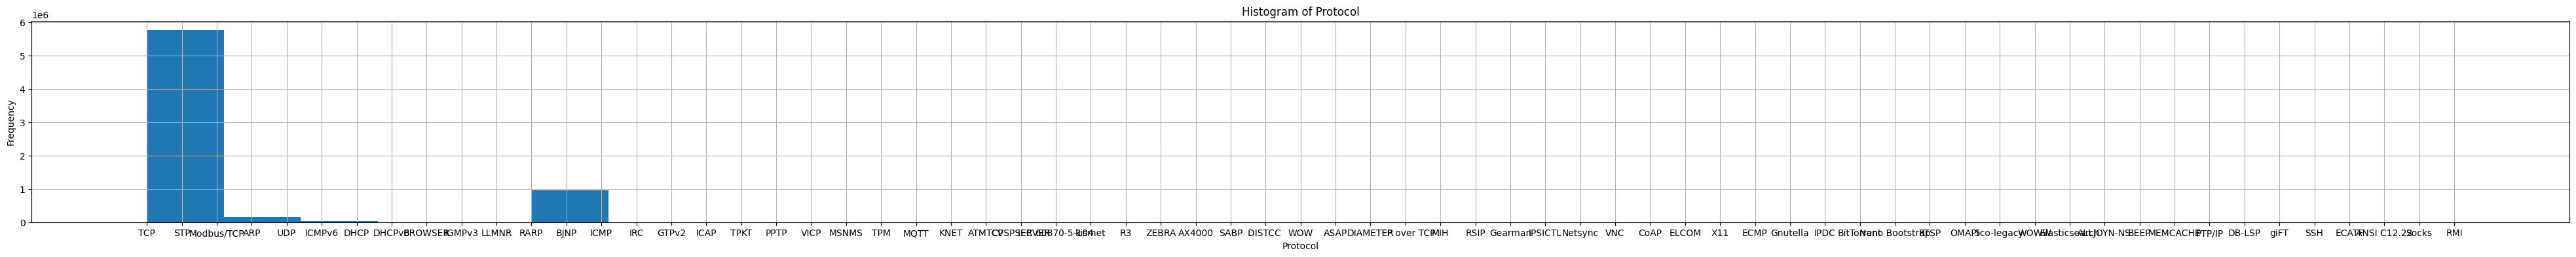

In [104]:
# For each column in the DataFrame
for column in data.columns:
    # Create a histogram
    if column == "Protocol": 
        continue
    plt.figure(figsize=(15, 4))
    data[column].hist(bins=50)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

plt.figure(figsize=(50, 4))
data['Protocol'].hist(bins=30)
plt.title(f"Histogram of Protocol")
plt.xlabel('Protocol')
plt.ylabel("Frequency")
plt.show()

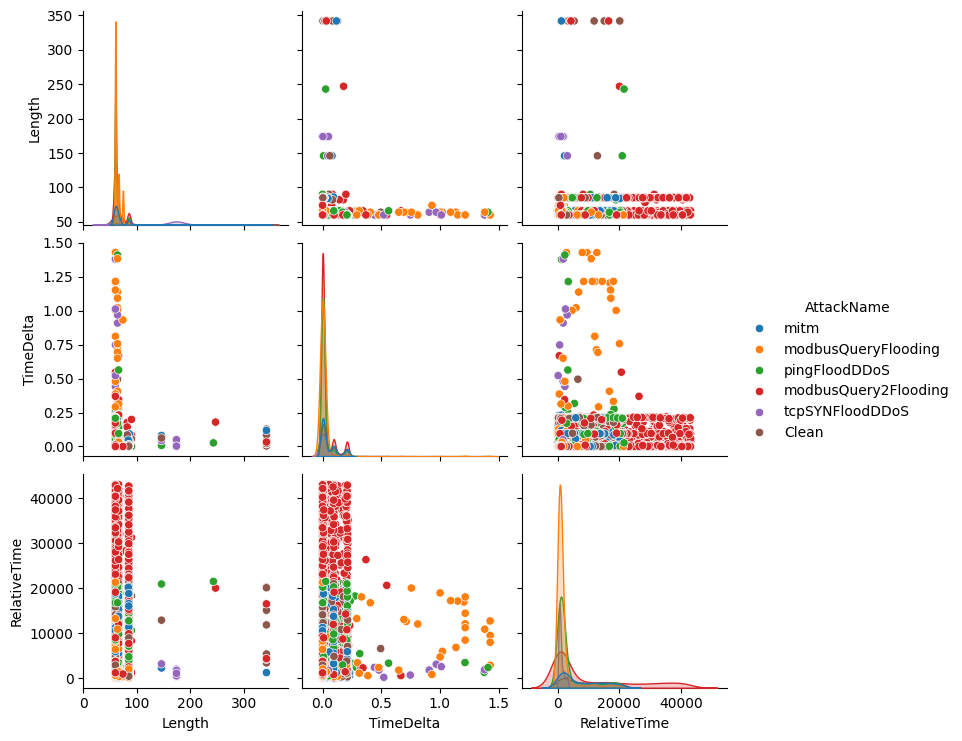

In [105]:
import seaborn as sns
#data.head()
sample_data = data.sample(n=9000) 
sns.pairplot(sample_data, vars=['Length', 'TimeDelta', 'RelativeTime'], hue='AttackName')
plt.show()


In [106]:

# verify the unique values for the attacks
print("Unique values in 'AttackName' before mapping:", data['AttackName'].unique())

Unique values in 'AttackName' before mapping: ['Clean' 'mitm' 'modbusQuery2Flooding' 'modbusQueryFlooding'
 'pingFloodDDoS' 'tcpSYNFloodDDoS']


In [107]:
# mapping dictionary, using label encoding to convert the attack names to integers
attack_name_mapping = {
    'Clean': 1,  
    'mitm': 2,
    'modbusQuery2Flooding': 3,
    'modbusQueryFlooding': 4,
    'pingFloodDDoS': 5,
    'tcpSYNFloodDDoS': 6
}

# Apply the mapping
data['AttackName'] = data['AttackName'].map(attack_name_mapping)

# Check the results of the mapping
print("Unique values in 'AttackName' after mapping:", data['AttackName'].unique())
print("Non-null values in 'AttackName' after mapping:", data['AttackName'].notnull().sum()) # total number of rows in 'AttackName' column that don't have null values
print("Null values in 'AttackName':", data['AttackName'].isnull().sum())
print(f"Protocol: {data['Protocol'].nunique()} unique values")


Unique values in 'AttackName' after mapping: [1 2 3 4 5 6]
Non-null values in 'AttackName' after mapping: 6889976
Null values in 'AttackName': 0
Protocol: 67 unique values


In [108]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd

# encoding the protocol as ordinal and the flags as label
ordinal_features = ['Protocol']
label_features = ['SYNFlag', 'ACKFlag']

ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_features)
label_encoder = LabelEncoder()

#fit transform 
data[ordinal_features] = ordinal_encoder.fit_transform(data[ordinal_features])
for col in label_features:
    data[col] = label_encoder.fit_transform(data[col].astype(str)) # convert the column value to string before encoding

# imputations in case of any missing values
imputer = SimpleImputer(strategy='most_frequent') # fill any missing values with the most frequent value in the column
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)


data = data.apply(pd.to_numeric, errors='coerce') # convert columns to numeric

# Split the dataset into features (X) and target (y)
X = data.drop(['AttackName'], axis=1)  
y = data['AttackName'].astype(int)

## Feature Selection and Training Models

- Performing feature selection on relevant features using SelectKBest
- Training models using Decision Tree, Random Forest and Gradient Boosting

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)
print(selector.scores_)
featuresArr = [];
print(selected_indices)
for col in data.columns:
    featuresArr.append(col);
for i in selected_indices:
    print(featuresArr[i])

X = data[featuresArr]  
y = data['AttackName']  # Select the target column


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaler = StandardScaler()
# normalize_x_train = scaler.fit_transform(x_train)
# normalize_x_test = scaler.transform(x_test)

# Initialize and train the models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, max_samples=0.5, max_features=0.5, random_state=42),
}

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)

    # report = classification_report(y_test, y_pred)
    # print(report)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Training Time: {train_time:.4f} seconds\n")

[4.34395187e+05 1.16057888e+06 8.10151768e+04 1.46548656e+06
 5.09698962e-02 6.74046217e+05]
[0 1 2 3 5]
Length
Protocol
SYNFlag
ACKFlag
RelativeTime
Decision Tree:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Training Time: 15.6494 seconds

Random Forest:
Accuracy: 0.9838
Precision: 0.9884
Recall: 0.9528
Training Time: 70.9812 seconds



In [128]:
from sklearn.metrics import classification_report

subset_data = data.sample(frac=1, random_state=42)  # originally was used to take a sample of data, but switched whole dataset
print(f"Number of rows in the subset: {subset_data.shape[0]}")

#using subset for training and testing
X2 = subset_data[featuresArr] 
y2 = subset_data['AttackName']  

# split the data into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

models = {
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, subsample=0.5, max_features=0.5, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X2_train, y2_train)
    train_time = time.time() - start_time
    y2_pred = model.predict(X2_test)
    
    accuracy = accuracy_score(y2_test, y2_pred)
    precision = precision_score(y2_test, y2_pred, average='macro', zero_division=0)
    recall = recall_score(y2_test, y2_pred, average='macro', zero_division=0)
    
    print(f"{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Training Time: {train_time:.4f} seconds\n")

Number of rows in the subset: 6889976
Gradient Boosting:
Accuracy: 0.9989
Precision: 0.9994
Recall: 0.9985
Training Time: 368.3565 seconds



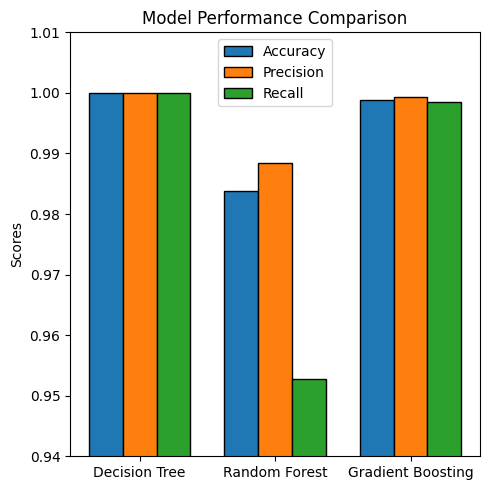

In [130]:
import matplotlib.pyplot as plt

# Model names and their performances
models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
accuracies = [1.000, 0.9838, 0.9989]
precisions = [1.000, 0.9884, 0.9994]
recalls = [1.000, 0.9528, 0.9985]

# create plots
fig, ax = plt.subplots(figsize=(5, 5))
width = 0.25
x = range(len(models))

# Plotting each metric
ax.bar(x, accuracies, width, label='Accuracy', edgecolor='black')
ax.bar([p + width for p in x], precisions, width, label='Precision', edgecolor='black')
ax.bar([p + width*2 for p in x], recalls, width, label='Recall', edgecolor='black')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(models)
ax.set_ylim([0.94, 1.01])
ax.legend()

plt.tight_layout()
plt.show()
